### Install necessary libraries

In [3]:
# !pip install langdetect
# !pip install emoji
# !pip install transformers
# !pip install tensorflow

### Import libraries

In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


from langdetect import detect
import re
import matplotlib.pyplot as plt
import seaborn as sns

import emoji
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, Trainer

import warnings
warnings.filterwarnings("ignore")

### Download nltk packages

In [5]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stama\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stama\AppData\Roaming\nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\stama\AppData\Roaming\nltk_data...


True

### Input files

In [8]:
comments_path = 'Comments.csv'
labelled_path = 'final_labelled_data.csv'

In [9]:
# Loading the data into pandas dataframes
df_comments = pd.read_csv(comments_path)
df_labelled = pd.read_csv(labelled_path)

FileNotFoundError: [Errno 2] No such file or directory: 'Comments.csv'

## Data preprocessing

### Drop these comlumns

In [ ]:
df_labelled = df_labelled.dropna(subset=['Topic', 'Comment'])

### Function to check english comments

In [ ]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Remove non-English comments
df_labelled = df_labelled[df_labelled['Comment'].apply(is_english)]

### Data parameters

In [ ]:
# This is the total number of samples you want.
n_samples = 20000

# The number of unique topics.
n_categories = df_labelled['Topic'].nunique()

# Calculate the number of samples per each category.
samples_per_category = n_samples // n_categories

In [ ]:
# Now you can create a new dataframe with an equal number of samples from each category.
df_labelled = df_labelled.groupby('Topic').apply(lambda x: x.sample(min(len(x), samples_per_category))).reset_index(drop=True)

### Preprocessing Labelled data

In [ ]:
def remove_emoji(text):
    return emoji.demojize(text, delimiters=("", ""))

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    
    text = remove_emoji(text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = word_tokenize(text.lower())    
    text = [w for w in text if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [token for token in text if token.isalnum()]
    return ' '.join(text)

In [ ]:
df_labelled['Comment']=df_labelled['Comment'].apply(preprocess_text)

### Convert score to sentiment classes

In [ ]:
def score_to_label(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df_labelled['Sentiment_Label'] = df_labelled['Sentiment'].apply(score_to_label)

## Data visualize

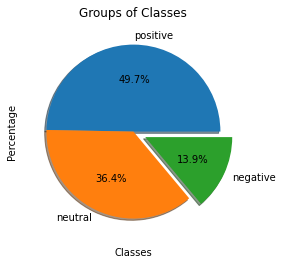

In [ ]:
plt.figure(figsize=(8, 4))
df_labelled.groupby('Sentiment_Label')['Sentiment_Label'].count().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', explode=(0, 0, 0.15), shadow=True)
plt.title("Groups of Classes")
plt.ylabel('Percentage')
plt.xlabel('Classes')
plt.show()

**Based on the data, the majority of the classes fall under the "positive" category, accounting for 49.7% of the data. The "neutral" class follows with 36.4%, while the "negative" class represents the smallest portion at 13.9%. This distribution suggests a relatively optimistic sentiment overall, with a significant portion of the data expressing positive opinions or views.**

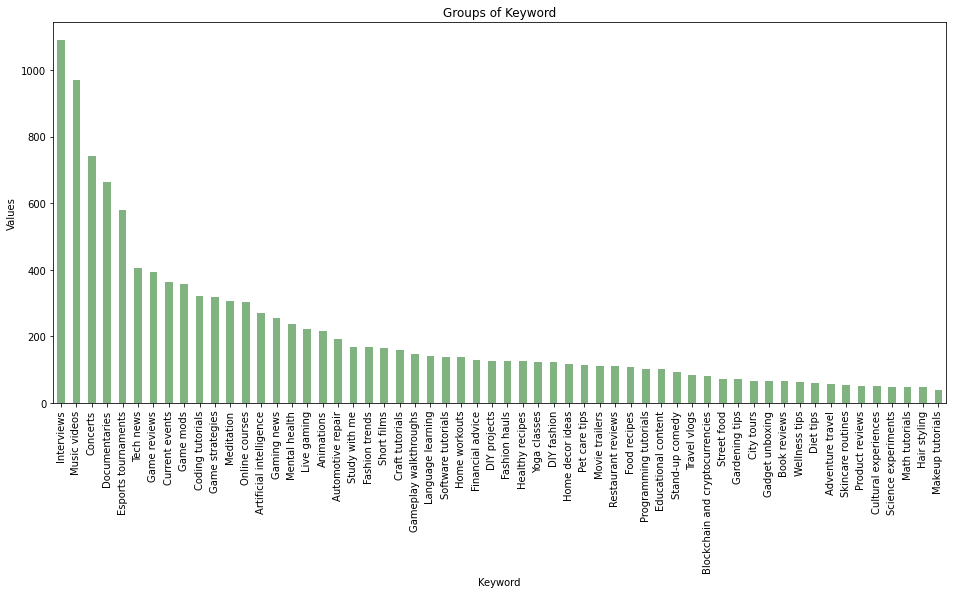

In [ ]:
plt.figure(figsize=(16, 7))
df_labelled.groupby('Keyword')['Keyword'].count().sort_values(ascending=False).plot(kind='bar', color=(0.5, 0.7, 0.5))
plt.title("Groups of Keyword")
plt.ylabel('Values')
plt.xlabel('Keyword')
plt.show()

**We can observed that the top three keywords with the highest counts are "Interviews," "Music videos," and "Concerts." This suggests a strong interest in media-related content, with a focus on interviews and music-related experiences. Other popular keywords include documentaries, esports tournaments, and tech news, indicating a diverse range of preferences and interests among viewers. Additionally, keywords such as coding tutorials, game strategies, and online courses highlight the popularity of educational and skill-building content in various fields**

In [ ]:
df_labelled['Topic'] = df_labelled['Topic'].apply(lambda x: " ".join(x.split('/')[-1].split('_')))

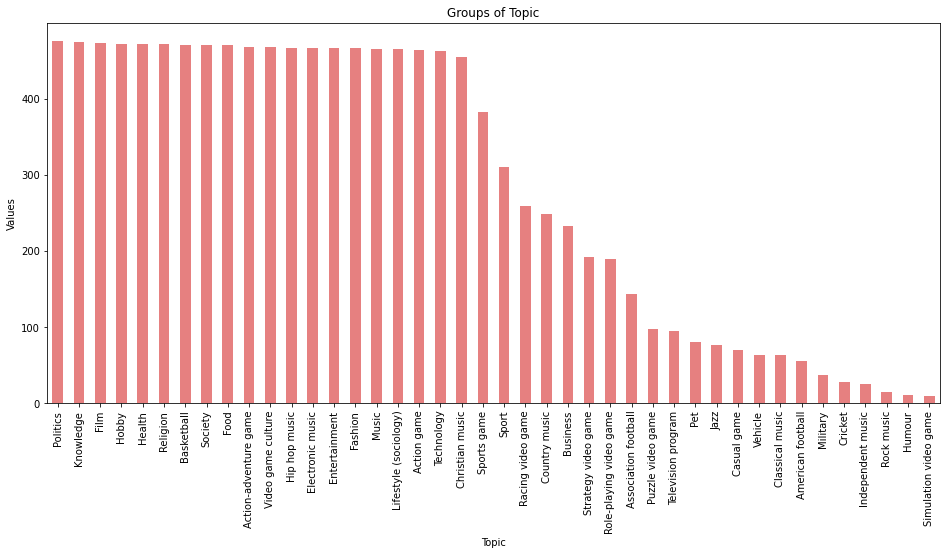

In [ ]:
plt.figure(figsize=(16, 7))
df_labelled.groupby('Topic')['Topic'].count().sort_values(ascending=False).plot(kind='bar', color=(0.9, 0.5, 0.5))
plt.title("Groups of Topic")
plt.ylabel('Values')
plt.xlabel('Topic')
plt.show()

**We can observed that the topics with the highest counts are politics, hobby, and film. These three topics seem to generate the most interest and discussions among individuals. Other popular topics include food, knowledge, and action-adventure games, reflecting the diverse range of interests people have.**

#### Word cloud for 'Comment' column

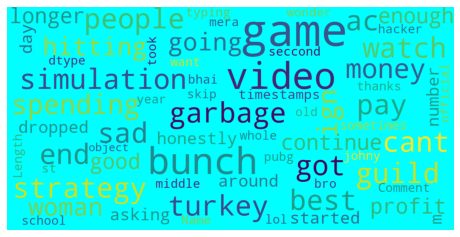

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='cyan',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df_labelled['Comment'])

#### Top words frequency

In [ ]:
top_N = 20

a = df_labelled['Comment'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

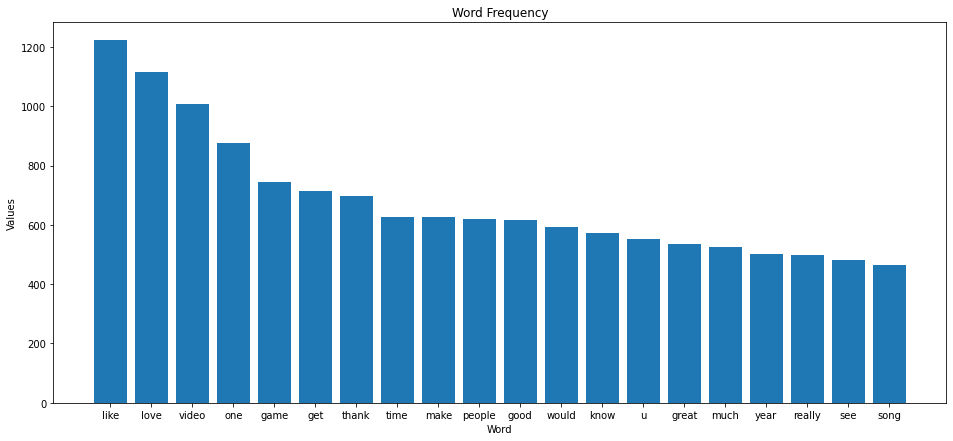

In [ ]:
plt.figure(figsize=(16, 7))
plt.bar(rslt['Word'], rslt['Frequency'])
plt.title("Word Frequency")
plt.ylabel('Values')
plt.xlabel('Word')
plt.show()

**'The' is most frequency in 'Comment' column, then to word 'i' because these words are very common in comments**

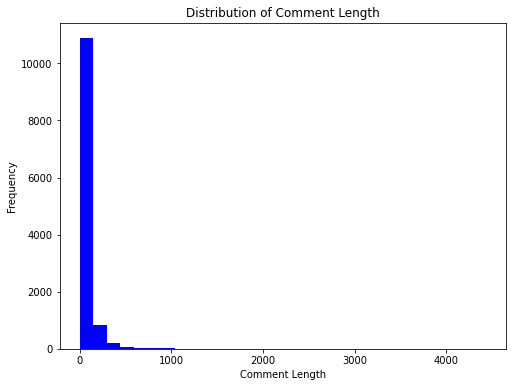

In [ ]:
df_labelled['comment_length'] = df_labelled['Comment'].apply(lambda x: len(str(x)))
df_labelled['tokenized_comments'] = df_labelled['Comment'].apply(lambda x: [word.lower() for word in word_tokenize(str(x)) if word.lower() not in stopwords])


# Plotting the length of comments
plt.figure(figsize=(8, 6))
plt.hist(df_labelled['comment_length'], bins=30, color='blue')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Length')
plt.show()

**Most of comments have length less than 100, by the way have very less comments more than 500 words. It's mean users usually comment shortly and Youtube limit length of comment.**

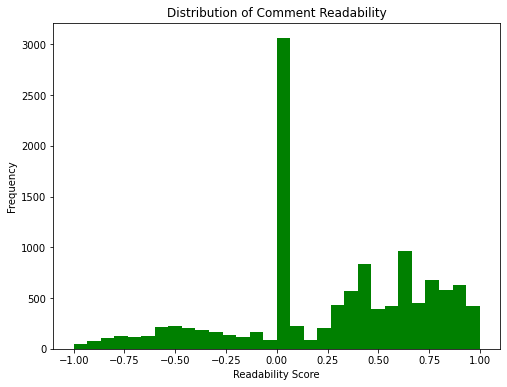

In [ ]:
# Calculate readability scores using sentiment analysis
sia = SentimentIntensityAnalyzer()
df_labelled['readability'] = df_labelled['Comment'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Plotting the readability scores
plt.figure(figsize=(8, 6))
plt.hist(df_labelled['readability'], bins=30, color='green')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Readability')
plt.show()

**The score highest at 0 and then evenly distributed to both sides.**

In [ ]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df_labelled['Sentiment_Label'] = df_labelled['Sentiment_Label'].map(label_map)

### Split dataset to train and test

In [ ]:
train_df, test_df = train_test_split(df_labelled, test_size=0.2, random_state=42)

## Bert model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['Comment'].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['Comment'].tolist(), truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['Sentiment_Label'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['Sentiment_Label'].tolist()
))

### Pretrained model

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Training

In [ ]:
epochs = 5
batch_size = 32

In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(batch_size), epochs=epochs, batch_size=batch_size)

Epoch 1/5
302/302 [==============================] - 164s 490ms/step - loss: 0.5803 - sparse_categorical_accuracy: 0.7650
Epoch 2/5
302/302 [==============================] - 149s 492ms/step - loss: 0.3054 - sparse_categorical_accuracy: 0.8900
Epoch 3/5
302/302 [==============================] - 149s 492ms/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9309
Epoch 4/5
302/302 [==============================] - 148s 492ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9534
Epoch 5/5
302/302 [==============================] - 149s 492ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9699


### Training graphs

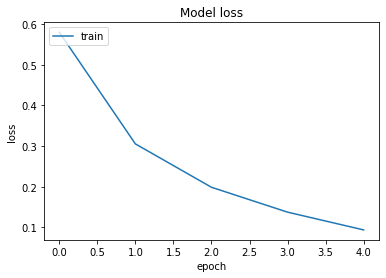

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

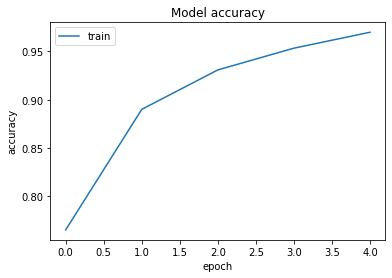

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

**In this training process, we trained Bert model for 5 epochs on a dataset consisting of 302 steps per epoch. The model achieved a decreasing loss value from 0.5803 to 0.0937 and an increasing sparse categorical accuracy from 0.7650 to 0.9699, indicating improved performance and successful learning throughout the epochs.**

### Save model

In [ ]:
model_path = "comment"
model.save_pretrained(model_path)

### Evaluate on testset

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size), verbose=0)
print(f"Test Loss: {test_loss}\nAccuracy: {test_accuracy}")

Test Loss: 0.37564030289649963
Accuracy: 0.892901599407196


## Vader

In [ ]:
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis on comments
df_labelled['vader_scores'] = df_labelled['Comment'].apply(lambda x: sia.polarity_scores(x))

# Extract the compound score
df_labelled['vader_compound'] = df_labelled['vader_scores'].apply(lambda x: x['compound'])

# Convert the compound score to sentiment label
df_labelled['vader_pred'] = df_labelled['vader_compound'].apply(lambda x : 2 if x >= 0.05 else (1 if x <= -0.05 else 0))

### Evaluate vader

In [ ]:
# Calculate the accuracy
accuracy = (df_labelled['vader_pred'] == df_labelled['Sentiment_Label']).mean()

print(f"Accuracy of VADER sentiment analysis: {accuracy}")

Accuracy of VADER sentiment analysis: 0.5024082378342468


**The model trained in the previous example achieved a sparse categorical accuracy of 0.9699, which indicates a high level of accuracy in classifying the data. On the other hand, the VADER sentiment analysis model achieved an accuracy of 0.5024, which suggests that it performs at a relatively lower level compared to the previous model. The Bert model demonstrates better performance in terms of accuracy because it's suitable for text**

## Applying the sentimental model to the unseen data

### Process comments data

In [ ]:
df_comments = df_comments[df_comments['Comment'].apply(is_english)]
df_comments['Comment'] = df_comments['Comment'].apply(preprocess_text)
df_comments.reset_index(drop=True, inplace=True)

**We remove non english comments then process comments data**

### Load the model and tokenizer

In [ ]:
model_path = "comment"
model = TFBertForSequenceClassification.from_pretrained(model_path, num_labels=3)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at comment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at comment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Define batch size
batch_size = 100

# Create an empty list to store predictions
predictions = []

# Loop over the comments in batches
for i in range(0, len(df_comments['Comment']), batch_size):
    # Tokenize the current batch of comments
    input_ids = tokenizer(df_comments['Comment'].iloc[i:i+batch_size].tolist(), padding=True, truncation=True, max_length=256, return_tensors='tf')

    # Make sentiment predictions for the current batch
    logits = model(input_ids)['logits']
    preds = tf.argmax(logits, axis=-1).numpy()

    # Append the predictions to the list
    predictions.extend(preds)

# Add the predictions as a new column in the dataframe
df_comments['Sentiment_Prediction'] = predictions

### Convert prediction to class labels

In [ ]:
label_map = {2: 'positive', 1: 'neutral', 0: 'negative'}
df_comments['Sentiment_Label'] = df_comments['Sentiment_Prediction'].map(label_map)

In [ ]:
df_comments

,Comment,Sentiment_Prediction,Sentiment_Label
0,bro iphone 11 new 128gb sahi rahega aya iphone...,2,positive
1,keep this series up i luv these kind of walkth...,2,positive
2,enders game that wa an awesome space movie tha...,2,positive
3,there a crusader king 2 mod called elder king ...,2,positive
4,the problem with be careful what you sign is t...,2,positive
...,...,...,...
7058,for me richarlyson song wa the best,2,positive
7059,bro i need a 10 thousand diamond,1,neutral
7060,big griff always killin it love ya man,2,positive
7061,shadow ka lag issue solve hoo jaye ba fir miln...,1,neutral


## DistilRoBert topic model

### Create class for data preparation

In [ ]:
class ProcessDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### Load tokenizer and model

In [ ]:
model_name = "j-hartmann/emotion-english-distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

loading configuration file https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/resolve/main/config.json from cache at C:\Users\kien.tadinh/.cache\huggingface\transformers\cf0d76ef122b326527bd6a56a127784dd513117bdfde0df5b011c9751bce8fd6.512111953428ded6703782e47e2f67b1c438267f7f4a7c0f19bc1850651a93b4
Model config RobertaConfig {
  "_name_or_path": "j-hartmann/emotion-english-distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "joy",
    "4": "neutral",
    "5": "sadness",
    "6": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neut

**In this pretrained model we have 7 emotion classes: </br>
"0": "anger",</br>
"1": "disgust",</br>
"2": "fear",</br>
"3": "joy",</br>
"4": "neutral",</br>
"5": "sadness",</br>
"6": "surprise"**

### Tokenize texts and create prediction on labelled data

In [ ]:
tokenized_texts = tokenizer(list(df_labelled['Comment']), truncation=True, padding=True)
pred_dataset = ProcessDataset(tokenized_texts)

In [ ]:
# Run predictions
predictions = trainer.predict(pred_dataset)
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)

In [ ]:
df_labelled['Topic'] = labels

### Tokenize texts and create prediction on comments data

In [ ]:
tokenized_texts = tokenizer(list(df_comments['Comment']), truncation=True, padding=True)
pred_dataset = ProcessDataset(tokenized_texts)

In [ ]:
predictions = trainer.predict(pred_dataset)
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)

***** Running Prediction *****
  Num examples = 7063
  Batch size = 16


In [ ]:
df_comments['Topic'] = labels

In [ ]:
df_labelled

,Video ID,Comment,Keyword,Topic,Sentiment,Sentiment_Label,vader_scores,vader_compound,vader_pred
0,AT1R4VmZ8Kw,your channel is such a hidden gem more people ...,Gaming news,neutral,0.111111,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
1,OLN79BMaC3U,you honestly need these rating or review buy b...,Game reviews,neutral,0.600000,2,"{'neg': 0.159, 'neu': 0.588, 'pos': 0.253, 'co...",0.4019,2
2,YsqFrJXpQUw,what a background song,Esports tournaments,surprise,0.000000,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
3,HGxOq2Oi_78,it s sad that people pay 120 for a bunch of ga...,Game reviews,sadness,-0.500000,0,"{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compou...",-0.5423,1
4,p84BLCDOspU,i swear there absolutely nothing more pathetic...,Live gaming,sadness,0.080000,2,"{'neg': 0.124, 'neu': 0.713, 'pos': 0.162, 'co...",0.3491,2
...,...,...,...,...,...,...,...,...,...
12037,3kbJopmwxbk,man you explained this better than any highsch...,Game mods,surprise,0.500000,2,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...",0.5228,2
12038,9LyrmzQJQYQ,bhai mene kal install kya to mere phn me tourn...,Esports tournaments,neutral,-0.500000,0,"{'neg': 0.0, 'neu': 0.933, 'pos': 0.067, 'comp...",0.0772,2
12039,S63oOMhezNo,the yuggler concept art is fire,Game mods,anger,0.000000,1,"{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'comp...",-0.3400,1
12040,7h3cEVkONwQ,it just wont feel the same if you remove the n...,Gaming news,neutral,0.000000,1,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.0772,2


In [ ]:
df_comments

,Comment,Sentiment_Prediction,Sentiment_Label,Topic
0,bro iphone 11 new 128gb sahi rahega aya iphone...,2,positive,neutral
1,keep this series up i luv these kind of walkth...,2,positive,joy
2,enders game that wa an awesome space movie tha...,2,positive,joy
3,there a crusader king 2 mod called elder king ...,2,positive,joy
4,the problem with be careful what you sign is t...,2,positive,anger
...,...,...,...,...
7058,for me richarlyson song wa the best,2,positive,joy
7059,bro i need a 10 thousand diamond,1,neutral,neutral
7060,big griff always killin it love ya man,2,positive,anger
7061,shadow ka lag issue solve hoo jaye ba fir miln...,1,neutral,neutral


## Pipeline

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from langdetect import detect
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import emoji
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import pipeline


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

In [ ]:
df_labelled = pd.read_csv('final_labelled_data.csv')

### Pipeline class

**This pipeline to predict topic and sentiment on any video comments has id**

In [ ]:
class SentimentTopicModel:
    def __init__(self, data, sentiment_model_path, topic_model_path, num_labels, id_col_name='Video ID', 
                 comment_col_name='Comment'):
        self.data = data
        self.video_id_col_name = id_col_name
        self.comment_col_name = comment_col_name
        
        self.label_map = {2: 'positive', 1: 'neutral', 0: 'negative'}
        
        self.topic_model = pipeline("text-classification", model=topic_model_path, return_all_scores=True)
        
        self.sentiment_model = TFBertForSequenceClassification.from_pretrained(sentiment_model_path, num_labels=num_labels)
        self.sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def remove_emoji(self, text):
        return emoji.demojize(text, delimiters=("", ""))

    def preprocess_text(self, text):
        text = self.remove_emoji(text)
        text = re.sub(r'http\S+|www.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = word_tokenize(text.lower())
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(token) for token in text]
        text = [token for token in text if token.isalnum()]
        return ' '.join(text)
    
    def predict_sentiment(self, video_id):
        df_test = self.data[self.data[self.video_id_col_name]==video_id]
        results = []
        for text in df_test[self.comment_col_name].tolist():
            result = {
                'comment': text,
                'prediction': {}
            }
            processed_text = self.preprocess_text([text])
            input_ids = self.sentiment_tokenizer([processed_text], padding=True, truncation=True, 
                                                 max_length=256, return_tensors='tf')

            logits = self.sentiment_model(input_ids)['logits']
            pred_prob = tf.nn.softmax(logits).numpy()[0]
            for i, pred in enumerate(pred_prob):
                result['prediction'][self.label_map[i]]=pred
            results.append(result)
        return results
    
    def predict_topic(self, video_id):
        df_test = self.data[self.data[self.video_id_col_name]==video_id]
        results = []
        for text in df_test[self.comment_col_name].tolist():
            result = {
                'comment': text,
                'prediction': {}
            }
            
            processed_text = self.preprocess_text([text])
            
            label = self.topic_model(processed_text)
            for v in label:
                result['prediction'][v['label']]=v['score']
            results.append(result)
        return results

In [ ]:
pine = SentimentTopicModel(df_labelled, 
                           sentiment_model_path='comment', 
                           topic_model_path='j-hartmann/emotion-english-distilroberta-base', 
                           num_labels=3)

Some layers from the model checkpoint at comment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at comment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


#### Video id to test

In [ ]:
test_video_id = 'AT1R4VmZ8Kw'

#### Sentiment model

In [ ]:
sentiment = pine.predict_sentiment(video_id=test_video_id)

In [ ]:
sentiment

[{'comment': 'Your channel is such a hidden gem, more people need to discover it.',
  'prediction': {'negative': 0.0003951388,
   'neutral': 0.0021715553,
   'positive': 0.99743336}},
 {'comment': "I'm on my one-man crusade against Nintendo because they have a monopoly on nostalgia and they abuse the crap out of it. So, I won't be playing the new Zelda.",
  'prediction': {'negative': 0.98398006,
   'neutral': 0.014507065,
   'positive': 0.001512929}}]

#### Topic model

In [ ]:
topic = pine.predict_topic(video_id=test_video_id)

In [ ]:
topic

[{'comment': 'Your channel is such a hidden gem, more people need to discover it.',
  'prediction': {'anger': 0.009180986322462559,
   'disgust': 0.0014627655036747456,
   'fear': 0.002868675161153078,
   'joy': 0.08101373165845871,
   'neutral': 0.6946433186531067,
   'sadness': 0.004975605756044388,
   'surprise': 0.20585490763187408}},
 {'comment': "I'm on my one-man crusade against Nintendo because they have a monopoly on nostalgia and they abuse the crap out of it. So, I won't be playing the new Zelda.",
  'prediction': {'anger': 0.9467114210128784,
   'disgust': 0.0011698236921802163,
   'fear': 0.001857985625974834,
   'joy': 0.017492348328232765,
   'neutral': 0.0016411361284554005,
   'sadness': 0.02958606369793415,
   'surprise': 0.0015412080101668835}}]